In [6]:
# General imports.
import pprint
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# ML-related imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Huggingface datasets.
from datasets import load_dataset

# Comparison of Bayesian Optimization Frameworks | Baselines

In this notebook we are going to create baseline models to later compare with models which used bayesian optimization techniques for parameter tuning.

## Global Settings

In [3]:
RANDOM_SEED = 42

In [8]:
dataset = load_dataset('maharshipandya/spotify-tracks-dataset')
print(f"Shape: {dataset.shape}")


Shape: {'train': (114000, 21)}


In [12]:
df = pd.DataFrame(dataset.get('train'))
print(f"Shape: {df.shape}")
df.info()

Shape: (114000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  

There is no pre defined machine learning task. For our purposes we will try a classification task in which we are trying to predict the `popularity` of a song. 

In [100]:
INT_FEATURES = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
print(f"There are {len(INT_FEATURES)} int features in the dataset")

FLOAT_FEATURES = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
print(f"There are {len(FLOAT_FEATURES)} float features in the dataset")

FEATURES = INT_FEATURES + FLOAT_FEATURES
TARGET_PRIOR = 'popularity'

FEATURES = [f for f in FEATURES if f not in [TARGET_PRIOR, 'Unnamed: 0']]

There are 6 int features in the dataset
There are 9 float features in the dataset


## Create Own Target Feature

In [101]:
# Split popularity into buckets 
df[TARGET_PRIOR].describe()

count    114000.000000
mean         33.238535
std          22.305078
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

In [114]:
bins = np.arange(0, 101, 10)
labels = np.arange(0, len(bins)-1, 1)
assert len(bins) == len(labels)+1, f"len(bins) = {len(bins)} != {len(labels)}+1 = len(labels)"

df['popularity_bucket'] = pd.cut(df[TARGET_PRIOR], 
                                 bins=bins, 
                                 labels=labels, 
                                 include_lowest=True)

TARGET = 'popularity_bucket' 
df['popularity_bucket'].value_counts()                                

0    23462
4    18904
2    17579
3    15570
5    14200
1    10715
6     8724
7     3892
8      886
9       68
Name: popularity_bucket, dtype: int64

## Train and Evaluate the Model

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], 
                                                    df[TARGET], 
                                                    test_size=0.15,
                                                    random_state=RANDOM_SEED,
                                                    stratify=df[TARGET])
print(f"""
Shapes
======
    train: {X_train.shape}
    test : {X_test.shape}      
""")


Shapes
    train: (96900, 13)
    test : (17100, 13)      



In [116]:

def predict_and_summarize(X_train_scaled,
                          X_test_scaled, 
                          y_train, 
                          y_test,
                          clf,
                          model_type):

    y_pred_train = clf.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_rec = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    train_f1 = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    y_pred = clf.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"""
    Performance Results : {model_type} 
    ========================================
                    {'Train':<10}{'Test':<10}
        Accuracy  : {train_acc:<10.4f}{test_acc:<10.4f}
        Precision : {train_prec:<10.4f}{test_prec:<10.4f}
        Recall    : {train_rec:<10.4f}{test_rec:<10.4f}
        F1-Score  : {train_f1:<10.4f}{test_f1:<10.4f}
    """)

    return {'y_pred_train': y_pred_train, 'y_pred_test': y_pred}

## Dataset Preparation

In [117]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Models

Let's train a small baseline model to get a feeling for how much better the bayesian optimizated models will get.

### LogisticRegression

In [118]:
y_train.value_counts()

0    19943
4    16068
2    14942
3    13235
5    12070
1     9108
6     7415
7     3308
8      753
9       58
Name: popularity_bucket, dtype: int64

In [119]:
lrc = LogisticRegression()

lrc.fit(X_train_scaled, y_train)

y_preds = predict_and_summarize(X_train_scaled,
                                X_test_scaled, 
                                y_train, 
                                y_test,
                                lrc,
                                'LogisticRegression')

/Users/clemens.woest/opt/anaconda3/envs/bayes_opt_battle_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



    Performance Results : LogisticRegression 
                    Train     Test      
        Accuracy  : 0.2478    0.2472    
        Precision : 0.1465    0.1428    
        Recall    : 0.1444    0.1436    
        F1-Score  : 0.1198    0.1186    
    


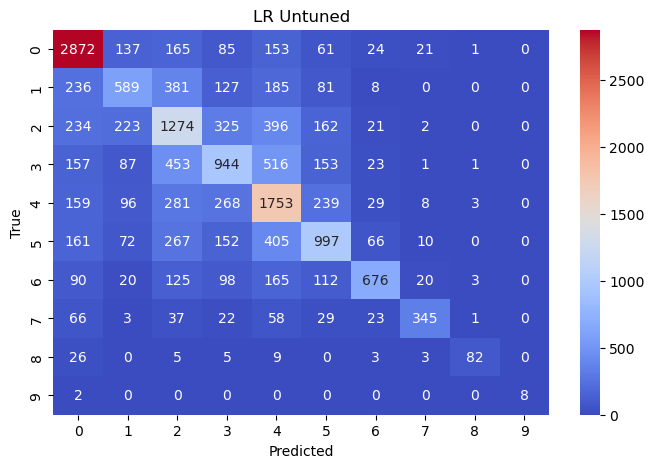

In [126]:
cm = confusion_matrix(y_test, y_preds.get('y_pred_test'))
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LR Untuned')

plt.savefig('../../imgs/spotify_tracks/lr_cm_untuned.png', dpi=300, bbox_inches='tight')

plt.show()

### RandomForestClassifier

In [121]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED)

rfc.fit(X_train_scaled, y_train)

y_preds = predict_and_summarize(X_train_scaled,
                                X_test_scaled, 
                                y_train, 
                                y_test,
                                rfc,
                                'RandomForestClassifier')


    Performance Results : RandomForestClassifier 
                    Train     Test      
        Accuracy  : 0.9867    0.5579    
        Precision : 0.9817    0.6632    
        Recall    : 0.9590    0.5680    
        F1-Score  : 0.9698    0.6044    
    


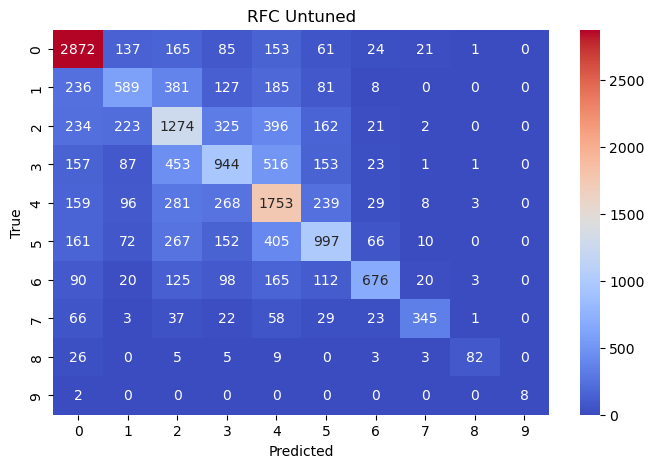

In [125]:
cm = confusion_matrix(y_test, y_preds.get('y_pred_test'))
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, 
            annot=True, 
            cmap='coolwarm', 
            fmt='d', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RFC Untuned')

plt.savefig('../../imgs/spotify_tracks/rfc_cm_untuned.png', dpi=300, bbox_inches='tight')

plt.show()